In [1]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt 
import seaborn as sns
import time

from sklearn.metrics import r2_score,mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler,PowerTransformer

import lightgbm as lgb
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import shap

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("SeagoingShip-Sensor-data.csv")
df['13_ballast'] = df['13_ballast'].map({'laden': 1, 'ballast': 0})
df['27_Prop_slip'] = df['27_Prop_slip'].map({'a': 0, 'b': 1})
df = df.drop("7_Fuel_Index", axis=1)
df = df.drop("2_Fuel_eff", axis=1)

In [3]:
df.columns

Index(['0_datetime', '1_Pickup11', '3_ME_tot_FL', '4_Nav_02', '5_Nav_03',
       '6_Nav_04', '8_MSB0-TOT-LOD', '9_MS114', '10_MW014',
       '11_Trim_in_meters', '12_LIST', '13_ballast', '14_ECDIS_COG',
       '15_Uwind', '16_Vwind', '17_Gust', '18_Significant_wave_height',
       '19_Wave_direction', '20_Wave_period', '21_struja_smjer_deg',
       '22_struja_brzina', '23_sea', '24_swell', '25_wind',
       '26_wind_deg_ecdis', '27_Prop_slip'],
      dtype='object')

In [4]:
df.shape

(18499, 26)

In [5]:
nan_rows = df[df.isna().any(axis=1)]
nan_rows.shape

(9262, 26)

# 10Min

In [201]:
df['0_datetime'] = pd.to_datetime(df['0_datetime'], format='%m/%d/%Y %H:%M')  #%Y-%m-%d %H:%M
data_10m = df.groupby(pd.Grouper(key='0_datetime',freq='10Min')).aggregate(np.mean)
data_10m.shape

(29232, 25)

In [202]:
data_10m = data_10m.dropna()
data_10m.shape

(5378, 25)

In [203]:
data_10m.to_csv("10min_seagoing_clean"".csv")

# 20Min

In [204]:
df['0_datetime'] = pd.to_datetime(df['0_datetime'], format='%m/%d/%Y %H:%M')  #%Y-%m-%d %H:%M
data_20m = df.groupby(pd.Grouper(key='0_datetime',freq='20Min')).aggregate(np.mean)
data_20m.shape

(14616, 25)

In [205]:
data_20m = data_20m.dropna()
data_20m.shape

(2889, 25)

In [206]:
data_20m.to_csv("20min_seagoing_clean"".csv")

# 30Min

In [207]:
df['0_datetime'] = pd.to_datetime(df['0_datetime'], format='%m/%d/%Y %H:%M')  #%Y-%m-%d %H:%M
data_30m = df.groupby(pd.Grouper(key='0_datetime',freq='30Min')).aggregate(np.mean)
data_30m.shape

(9744, 25)

In [208]:
data_30m = data_30m.dropna()
data_30m.shape

(2045, 25)

In [209]:
data_30m.to_csv("30min_seagoing_clean"".csv")

# 40Min

In [210]:
df['0_datetime'] = pd.to_datetime(df['0_datetime'], format='%m/%d/%Y %H:%M')  #%Y-%m-%d %H:%M
data_40m = df.groupby(pd.Grouper(key='0_datetime',freq='40Min')).aggregate(np.mean)
data_40m.shape

(7308, 25)

In [211]:
data_40m = data_40m.dropna()
data_40m.shape

(1561, 25)

In [212]:
data_40m.to_csv("40min_seagoing_clean"".csv")

# 50Min

In [213]:
df['0_datetime'] = pd.to_datetime(df['0_datetime'], format='%m/%d/%Y %H:%M')  #%Y-%m-%d %H:%M
data_50m = df.groupby(pd.Grouper(key='0_datetime',freq='50Min')).aggregate(np.mean)
data_50m.shape

(5847, 25)

In [214]:
data_50m = data_50m.dropna()
data_50m.shape

(1293, 25)

In [215]:
data_50m.to_csv("50min_seagoing_clean"".csv")

# 60Min

In [216]:
df['0_datetime'] = pd.to_datetime(df['0_datetime'], format='%m/%d/%Y %H:%M')  #%Y-%m-%d %H:%M
data_60m = df.groupby(pd.Grouper(key='0_datetime',freq='60Min')).aggregate(np.mean)
data_60m.shape

(4872, 25)

In [217]:
data_60m = data_60m.dropna()
data_60m.shape

(1110, 25)

In [218]:
data_60m.to_csv("60min_seagoing_clean"".csv")

# Groupes similaires

In [4]:
df = pd.read_csv("SeagoingShip-Sensor-data.csv")
df = df.set_index('0_datetime')
df['13_ballast'] = df['13_ballast'].map({'laden': 1, 'ballast': 0})
df['27_Prop_slip'] = df['27_Prop_slip'].map({'a': 0, 'b': 1})
df = df.drop("7_Fuel_Index", axis=1)
df = df.drop("2_Fuel_eff", axis=1)
df = df.drop("3_ME_tot_FL", axis=1) #target 

In [220]:
corr_matrix = df.corr()

In [221]:
distance_matrix = 1 - corr_matrix

In [222]:
nan_rows = distance_matrix[distance_matrix.isna().any(axis=1)]
nan_rows

,1_Pickup11,4_Nav_02,5_Nav_03,6_Nav_04,8_MSB0-TOT-LOD,9_MS114,10_MW014,11_Trim_in_meters,12_LIST,13_ballast,14_ECDIS_COG,15_Uwind,16_Vwind,17_Gust,18_Significant_wave_height,19_Wave_direction,20_Wave_period,21_struja_smjer_deg,22_struja_brzina,23_sea,24_swell,25_wind,26_wind_deg_ecdis,27_Prop_slip


In [223]:
Z = linkage(distance_matrix, method='single')#ward

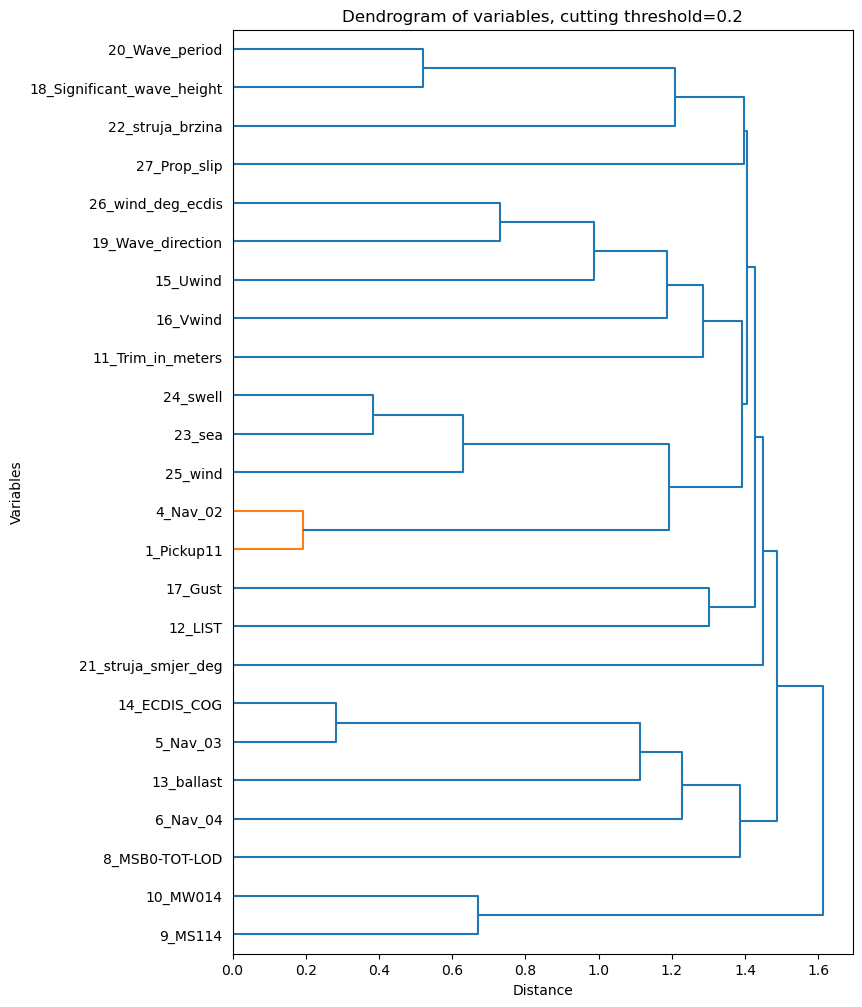

In [224]:
plt.figure(figsize=(8, 12))
dendrogram(Z, labels=corr_matrix.columns, color_threshold=0.2,orientation='right')#, leaf_rotation=90
plt.title('Dendrogram of variables, cutting threshold=0.2')
plt.xlabel('Distance')
plt.ylabel('Variables')
plt.show()

In [225]:
t = 0.2
clusters = fcluster(Z, t=t, criterion='distance')

grouped_vars = {}
for i, var in enumerate(corr_matrix.columns):
    group = clusters[i]
    if group not in grouped_vars:
        grouped_vars[group] = []
    grouped_vars[group].append(var)
    
print("Groupes de variables similaires :")
for group, variables in grouped_vars.items():
    print(f"Groupe {group} : {len(variables)} variables : {variables}")

Groupes de variables similaires :
Groupe 10 : 2 variables : ['1_Pickup11', '4_Nav_02']
Groupe 3 : 1 variables : ['5_Nav_03']
Groupe 6 : 1 variables : ['6_Nav_04']
Groupe 7 : 1 variables : ['8_MSB0-TOT-LOD']
Groupe 1 : 1 variables : ['9_MS114']
Groupe 2 : 1 variables : ['10_MW014']
Groupe 18 : 1 variables : ['11_Trim_in_meters']
Groupe 8 : 1 variables : ['12_LIST']
Groupe 5 : 1 variables : ['13_ballast']
Groupe 4 : 1 variables : ['14_ECDIS_COG']
Groupe 16 : 1 variables : ['15_Uwind']
Groupe 17 : 1 variables : ['16_Vwind']
Groupe 9 : 1 variables : ['17_Gust']
Groupe 19 : 1 variables : ['18_Significant_wave_height']
Groupe 14 : 1 variables : ['19_Wave_direction']
Groupe 20 : 1 variables : ['20_Wave_period']
Groupe 23 : 1 variables : ['21_struja_smjer_deg']
Groupe 21 : 1 variables : ['22_struja_brzina']
Groupe 11 : 1 variables : ['23_sea']
Groupe 12 : 1 variables : ['24_swell']
Groupe 13 : 1 variables : ['25_wind']
Groupe 15 : 1 variables : ['26_wind_deg_ecdis']
Groupe 22 : 1 variables : [

In [226]:
variables = corr_matrix.columns  # Liste des noms de variables

groups_df = pd.DataFrame({
    'Variable': variables,
    'Groupe': clusters
})

groups_df

,Variable,Groupe
0,1_Pickup11,10
1,4_Nav_02,10
2,5_Nav_03,3
3,6_Nav_04,6
4,8_MSB0-TOT-LOD,7
5,9_MS114,1
6,10_MW014,2
7,11_Trim_in_meters,18
8,12_LIST,8
9,13_ballast,5


# 10Min

In [32]:
df10 = pd.read_csv("10min_seagoing_clean.csv")
df10 = df10.set_index('0_datetime')
df10.shape

(5378, 25)

In [33]:
scaler = StandardScaler()
data10 = scaler.fit_transform(df10)
data10 = pd.DataFrame(data10, columns=df10.columns)

In [34]:
X = data10.drop(columns=['3_ME_tot_FL'])
y = data10['3_ME_tot_FL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
model10 = xgb.XGBRegressor(random_state=42)
model10.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [231]:
pred_test=model10.predict(X_test)
print("predict Test : ",r2_score(y_test,pred_test))
pred_train=model10.predict(X_train)
print("predict Train : ",r2_score(y_train,pred_train))

predict Test :  0.9911885872289798
predict Train :  0.9998492623821912


In [36]:
explainer10 = shap.TreeExplainer(model10, feature_perturbation='interventional')
shap_values10 = explainer10.shap_values(X_test)

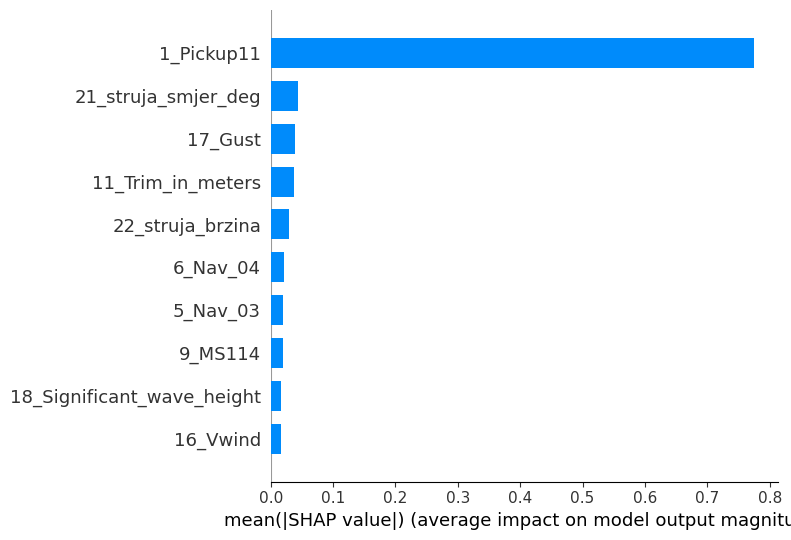

In [233]:
shap.summary_plot(shap_values10, X_test, plot_type="bar",max_display=10)

In [234]:
variables = X_test.columns
mean_abs_shap_values = np.mean(np.abs(shap_values10), axis=0)

shap_df10 = pd.DataFrame({
    'Variable': variables,
    'SHAP_value': mean_abs_shap_values
})

shap_df10 = shap_df10.merge(groups_df, on='Variable', how='left')

In [235]:
group_sizes = groups_df['Groupe'].value_counts()
valid_groups = group_sizes[group_sizes >= 2].index
shap_df10 = shap_df10[shap_df10['Groupe'].isin(valid_groups)]

In [236]:
shap_df10.to_csv("shap_df10_seagoing.csv")

# 20Min

In [37]:
df20 = pd.read_csv("20min_seagoing_clean.csv")
df20 = df20.set_index('0_datetime')
df20.shape

(2889, 25)

In [38]:
scaler = StandardScaler()
data20 = scaler.fit_transform(df20)
data20 = pd.DataFrame(data20, columns=df20.columns)

In [39]:
X = data20.drop(columns=['3_ME_tot_FL'])
y = data20['3_ME_tot_FL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
model20 = xgb.XGBRegressor(random_state=42) # 
model20.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [241]:
pred_test=model20.predict(X_test)
print("predict Test : ",r2_score(y_test,pred_test))
pred_train=model20.predict(X_train)
print("predict Train : ",r2_score(y_train,pred_train))

predict Test :  0.9726017054383126
predict Train :  0.9999512927975253


In [41]:
explainer20 = shap.TreeExplainer(model20, feature_perturbation='interventional')
shap_values20 = explainer20.shap_values(X_test)

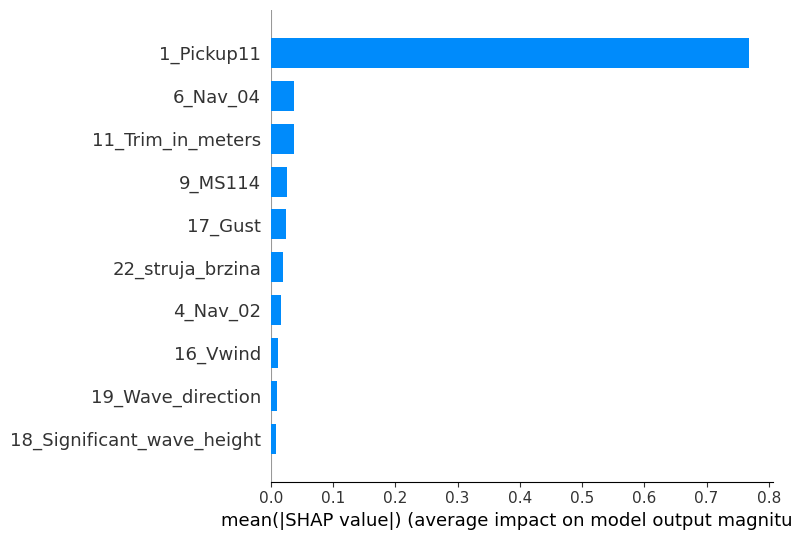

In [243]:
shap.summary_plot(shap_values20, X_test, plot_type="bar",max_display=10)

In [244]:
variables = X_test.columns
mean_abs_shap_values = np.mean(np.abs(shap_values20), axis=0)

shap_df20 = pd.DataFrame({
    'Variable': variables,
    'SHAP_value': mean_abs_shap_values
})

shap_df20 = shap_df20.merge(groups_df, on='Variable', how='left')

In [245]:
group_sizes = groups_df['Groupe'].value_counts()
valid_groups = group_sizes[group_sizes >= 2].index
shap_df20 = shap_df20[shap_df20['Groupe'].isin(valid_groups)]

In [246]:
shap_df20.to_csv("shap_df20_seagoing.csv")

# 30Min

In [42]:
df30 = pd.read_csv("30min_seagoing_clean.csv")
df30 = df30.set_index('0_datetime')
df30.shape

(2045, 25)

In [43]:
scaler = StandardScaler()
data30 = scaler.fit_transform(df30)
data30 = pd.DataFrame(data30, columns=df30.columns)

In [44]:
X = data30.drop(columns=['3_ME_tot_FL'])
y = data30['3_ME_tot_FL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [45]:
model30 = xgb.XGBRegressor(random_state=42)
model30.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [251]:
pred_test=model30.predict(X_test)
print("predict Test : ",r2_score(y_test,pred_test))
pred_train=model30.predict(X_train)
print("predict Train : ",r2_score(y_train,pred_train))

predict Test :  0.9822379981493599
predict Train :  0.9999789004873544


In [46]:
explainer30 = shap.TreeExplainer(model30, feature_perturbation='interventional')
shap_values30 = explainer30.shap_values(X_test)

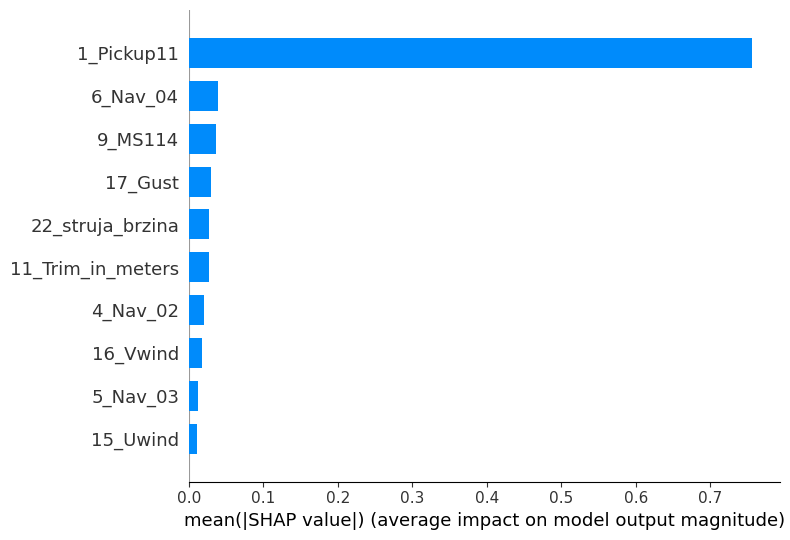

In [253]:
shap.summary_plot(shap_values30, X_test, plot_type="bar",max_display=10)

In [254]:
variables = X_test.columns
mean_abs_shap_values = np.mean(np.abs(shap_values30), axis=0)

shap_df30 = pd.DataFrame({
    'Variable': variables,
    'SHAP_value': mean_abs_shap_values
})

shap_df30 = shap_df30.merge(groups_df, on='Variable', how='left')

In [255]:
group_sizes = groups_df['Groupe'].value_counts()
valid_groups = group_sizes[group_sizes >= 2].index
shap_df30 = shap_df30[shap_df30['Groupe'].isin(valid_groups)]

In [256]:
shap_df30.to_csv("shap_df30_seagoing.csv")

# 40Min

In [47]:
df40 = pd.read_csv("40min_seagoing_clean.csv")
df40 = df40.set_index('0_datetime')
df40.shape

(1561, 25)

In [48]:
scaler = StandardScaler()
data40 = scaler.fit_transform(df40)
data40 = pd.DataFrame(data40, columns=df40.columns)

In [49]:
X = data40.drop(columns=['3_ME_tot_FL'])
y = data40['3_ME_tot_FL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
model40 = xgb.XGBRegressor(random_state=42)
model40.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [261]:
pred_test=model40.predict(X_test)
print("predict Test : ",r2_score(y_test,pred_test))
pred_train=model40.predict(X_train)
print("predict Train : ",r2_score(y_train,pred_train))

predict Test :  0.9916003768812554
predict Train :  0.9999842901852269


In [51]:
explainer40 = shap.TreeExplainer(model40, feature_perturbation='interventional')
shap_values40 = explainer40.shap_values(X_test)

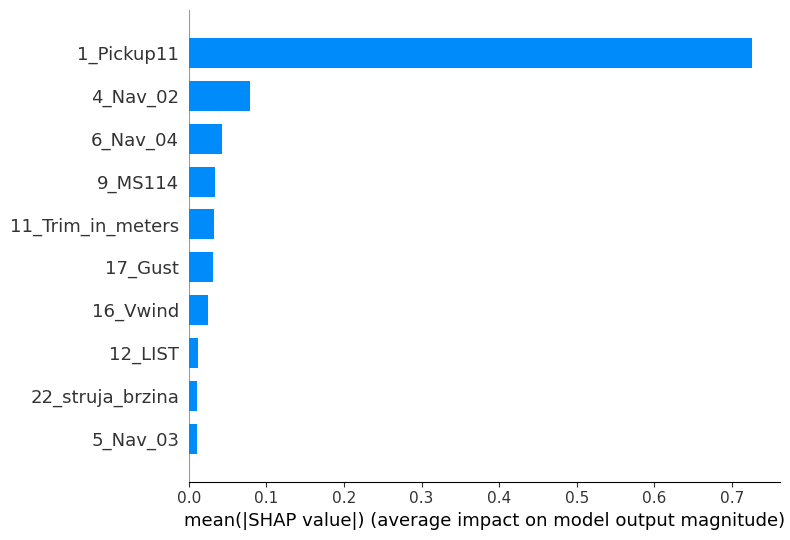

In [263]:
shap.summary_plot(shap_values40, X_test, plot_type="bar",max_display=10)

In [264]:
variables = X_test.columns
mean_abs_shap_values = np.mean(np.abs(shap_values40), axis=0)

shap_df40 = pd.DataFrame({
    'Variable': variables,
    'SHAP_value': mean_abs_shap_values
})

shap_df40 = shap_df40.merge(groups_df, on='Variable', how='left')

In [265]:
group_sizes = groups_df['Groupe'].value_counts()
valid_groups = group_sizes[group_sizes >= 2].index
shap_df40 = shap_df40[shap_df40['Groupe'].isin(valid_groups)]

In [266]:
shap_df40.to_csv("shap_df40_seagoing.csv")

# 50Min

In [52]:
df50 = pd.read_csv("50min_seagoing_clean.csv")
df50 = df50.set_index('0_datetime')
df50.shape

(1293, 25)

In [53]:
scaler = StandardScaler()
data50 = scaler.fit_transform(df50)
data50 = pd.DataFrame(data50, columns=df50.columns)

In [54]:
X = data50.drop(columns=['3_ME_tot_FL'])
y = data50['3_ME_tot_FL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [55]:
model50 = xgb.XGBRegressor(random_state=42)
model50.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [271]:
pred_test=model50.predict(X_test)
print("predict Test : ",r2_score(y_test,pred_test))
pred_train=model50.predict(X_train)
print("predict Train : ",r2_score(y_train,pred_train))

predict Test :  0.9681215764404808
predict Train :  0.9999947373710218


In [56]:
explainer50 = shap.TreeExplainer(model50, feature_perturbation='interventional')
shap_values50 = explainer50.shap_values(X_test)

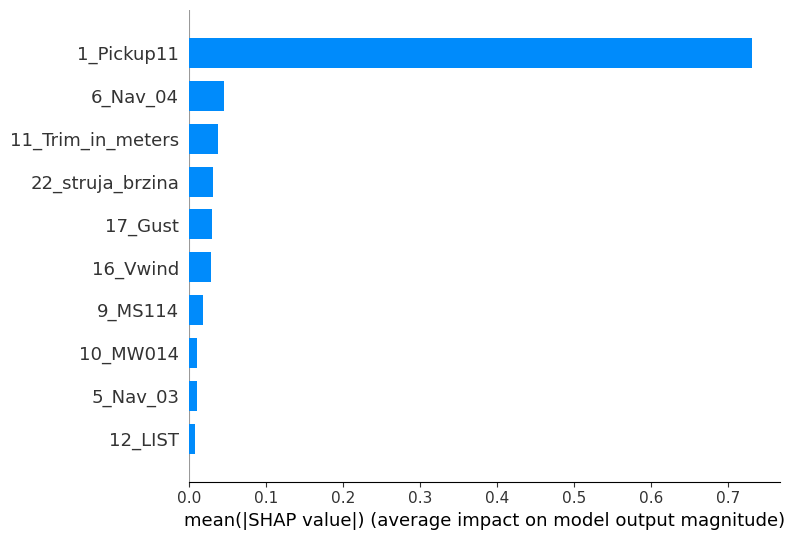

In [273]:
shap.summary_plot(shap_values50, X_test, plot_type="bar",max_display=10)

In [274]:
variables = X_test.columns
mean_abs_shap_values = np.mean(np.abs(shap_values50), axis=0)

shap_df50 = pd.DataFrame({
    'Variable': variables,
    'SHAP_value': mean_abs_shap_values
})

shap_df50 = shap_df50.merge(groups_df, on='Variable', how='left')

In [275]:
group_sizes = groups_df['Groupe'].value_counts()
valid_groups = group_sizes[group_sizes >= 2].index
shap_df50 = shap_df50[shap_df50['Groupe'].isin(valid_groups)]

In [276]:
shap_df50.to_csv("shap_df50_seagoing.csv")

# 60Min

In [57]:
df60 = pd.read_csv("60min_seagoing_clean.csv")
df60 = df60.set_index('0_datetime')
df60.shape

(1110, 25)

In [58]:
scaler = StandardScaler()
data60 = scaler.fit_transform(df60)
data60 = pd.DataFrame(data60, columns=df60.columns)

In [59]:
X = data60.drop(columns=['3_ME_tot_FL'])
y = data60['3_ME_tot_FL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [60]:
model60 = xgb.XGBRegressor(random_state=42)
model60.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [281]:
pred_test=model60.predict(X_test)
print("predict Test : ",r2_score(y_test,pred_test))
pred_train=model60.predict(X_train)
print("predict Train : ",r2_score(y_train,pred_train))

predict Test :  0.9726024038986921
predict Train :  0.9999957285992268


In [61]:
explainer60 = shap.TreeExplainer(model60, feature_perturbation='interventional')
shap_values60 = explainer60.shap_values(X_test)

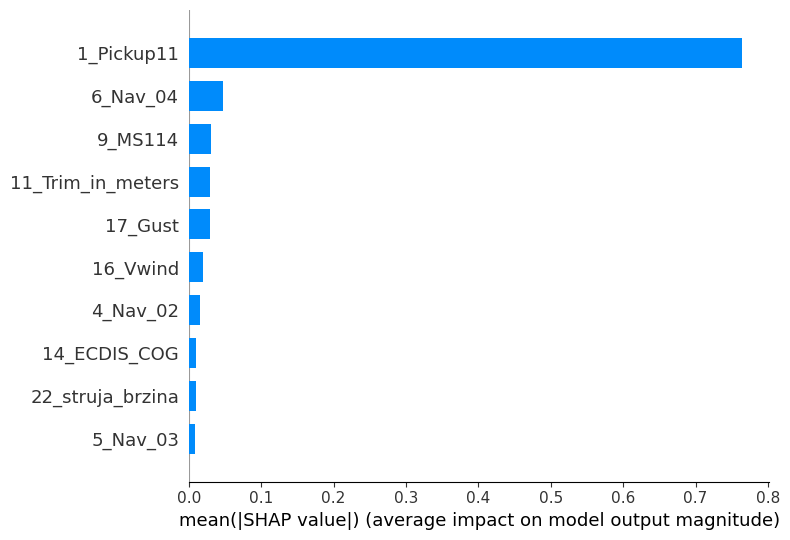

In [283]:
shap.summary_plot(shap_values60, X_test, plot_type="bar",max_display=10)

In [284]:
variables = X_test.columns
mean_abs_shap_values = np.mean(np.abs(shap_values60), axis=0)

shap_df60 = pd.DataFrame({
    'Variable': variables,
    'SHAP_value': mean_abs_shap_values
})

shap_df60 = shap_df60.merge(groups_df, on='Variable', how='left')

In [285]:
group_sizes = groups_df['Groupe'].value_counts()
valid_groups = group_sizes[group_sizes >= 2].index
shap_df60 = shap_df60[shap_df60['Groupe'].isin(valid_groups)]

In [286]:
shap_df60.to_csv("shap_df60_seagoing.csv")

In [287]:
np.save("shap_values10_seagoing.npy", shap_values10)
np.save("shap_values20_seagoing.npy", shap_values20)
np.save("shap_values30_seagoing.npy", shap_values30)
np.save("shap_values40_seagoing.npy", shap_values40)
np.save("shap_values50_seagoing.npy", shap_values50)
np.save("shap_values60_seagoing.npy", shap_values60)

# Coherence Analysis

In [6]:
shap_df10 = pd.read_csv("shap_df10_seagoing.csv")
shap_df20 = pd.read_csv("shap_df20_seagoing.csv")
shap_df30 = pd.read_csv("shap_df30_seagoing.csv")
shap_df40 = pd.read_csv("shap_df40_seagoing.csv")
shap_df50 = pd.read_csv("shap_df50_seagoing.csv")
shap_df60 = pd.read_csv("shap_df60_seagoing.csv")

In [7]:
shap_df10

,Unnamed: 0,Variable,SHAP_value,Groupe
0,0,1_Pickup11,0.774843,10
1,1,4_Nav_02,0.010011,10


In [8]:
coherence10 = shap_df10.groupby('Groupe')['SHAP_value'].std().mean()
print(coherence10)
coherence20 = shap_df20.groupby('Groupe')['SHAP_value'].std().mean()
print(coherence20)
coherence30 = shap_df30.groupby('Groupe')['SHAP_value'].std().mean()
print(coherence30)
coherence40 = shap_df40.groupby('Groupe')['SHAP_value'].std().mean()
print(coherence40)
coherence50 = shap_df50.groupby('Groupe')['SHAP_value'].std().mean()
print(coherence50)
coherence60 = shap_df60.groupby('Groupe')['SHAP_value'].std().mean()
print(coherence60)

0.5408174496054109
0.5316895411031487
0.5196421612354217
0.45706476814954444
0.5127422655905052
0.5291720040813528


In [9]:
frequences = [10,20,30,40,50,60]
coherences = {
    10:coherence10,
    20:coherence20,
    30:coherence30,
    40:coherence40,
    50:coherence50,
    60:coherence60
}

def cost_function(frequences,coherences):
    return coherences[frequences] 

cohr_costs= {f: cost_function(f, coherences) for f in frequences}
best_freq_coherence = min(cohr_costs, key=cohr_costs.get)

print(f"Optimal TA frequency (based on Coherence) : {best_freq_coherence} minutes.")

Optimal TA frequency (based on Coherence) : 40 minutes.


# Sensitivity Analysis

In [24]:
shap_values10 = np.load("shap_values10_seagoing.npy")
shap_values20 = np.load("shap_values20_seagoing.npy")
shap_values30 = np.load("shap_values30_seagoing.npy")
shap_values40 = np.load("shap_values40_seagoing.npy")
shap_values50 = np.load("shap_values50_seagoing.npy")
shap_values60 = np.load("shap_values60_seagoing.npy")

In [25]:
X = data10.drop(columns=['3_ME_tot_FL'])
y = data10['3_ME_tot_FL']
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
X = data20.drop(columns=['3_ME_tot_FL'])
y = data20['3_ME_tot_FL']
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
X = data30.drop(columns=['3_ME_tot_FL'])
y = data30['3_ME_tot_FL']
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
X = data40.drop(columns=['3_ME_tot_FL'])
y = data40['3_ME_tot_FL']
X_train_40, X_test_40, y_train_40, y_test_40 = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
X = data50.drop(columns=['3_ME_tot_FL'])
y = data50['3_ME_tot_FL']
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
X = data60.drop(columns=['3_ME_tot_FL'])
y = data60['3_ME_tot_FL']
X_train_60, X_test_60, y_train_60, y_test_60 = train_test_split(X, y, test_size=0.3, random_state=42)

In [62]:
def perturb_data_and_get_delta(data, epsilon=1e-4, random_seed=42):
    np.random.seed(random_seed)
    perturbation = np.random.normal(0, epsilon, data.shape)
    data_perturbed = data + perturbation
    delta = np.linalg.norm(perturbation)  # Calculer la norme de la perturbation
    return data_perturbed, delta

# Fonction pour calculer la différence entre les valeurs SHAP originales et perturbées
def calculate_shap_difference(original_shap, perturbed_shap):
    return np.linalg.norm(original_shap - perturbed_shap)

# Fonction pour calculer la sensibilité Lipschitzienne
def calculate_lipschitz_sensitivity(shap_difference, delta):
    return shap_difference / delta

# Perturber les données pour la fréquence de 10 minutes
X_test_perturbed_10, delta_10 = perturb_data_and_get_delta(X_test_10)
X_test_perturbed_20, delta_20 = perturb_data_and_get_delta(X_test_20)
X_test_perturbed_30, delta_30 = perturb_data_and_get_delta(X_test_30)
X_test_perturbed_40, delta_40 = perturb_data_and_get_delta(X_test_40)
X_test_perturbed_50, delta_50 = perturb_data_and_get_delta(X_test_50)
X_test_perturbed_60, delta_60 = perturb_data_and_get_delta(X_test_60)

# Calculer les valeurs SHAP pour les données perturbées
shap_values_perturbed_10 = explainer10.shap_values(X_test_perturbed_10)
shap_values_perturbed_20 = explainer20.shap_values(X_test_perturbed_20)
shap_values_perturbed_30 = explainer30.shap_values(X_test_perturbed_30)
shap_values_perturbed_40 = explainer40.shap_values(X_test_perturbed_40)
shap_values_perturbed_50 = explainer50.shap_values(X_test_perturbed_50)
shap_values_perturbed_60 = explainer60.shap_values(X_test_perturbed_60)

# Calculer la différence des valeurs SHAP et la sensibilité Lipschitzienne
shap_difference_10 = calculate_shap_difference(shap_values10, shap_values_perturbed_10)
shap_difference_20 = calculate_shap_difference(shap_values20, shap_values_perturbed_20)
shap_difference_30 = calculate_shap_difference(shap_values30, shap_values_perturbed_30)
shap_difference_40 = calculate_shap_difference(shap_values40, shap_values_perturbed_40)
shap_difference_50 = calculate_shap_difference(shap_values50, shap_values_perturbed_50)
shap_difference_60 = calculate_shap_difference(shap_values60, shap_values_perturbed_60)

lipschitz_sensitivity_10 = calculate_lipschitz_sensitivity(shap_difference_10, delta_10)
print(lipschitz_sensitivity_10)
lipschitz_sensitivity_20 = calculate_lipschitz_sensitivity(shap_difference_20, delta_20)
print(lipschitz_sensitivity_20)
lipschitz_sensitivity_30 = calculate_lipschitz_sensitivity(shap_difference_30, delta_30)
print(lipschitz_sensitivity_30)
lipschitz_sensitivity_40 = calculate_lipschitz_sensitivity(shap_difference_40, delta_40)
print(lipschitz_sensitivity_40)
lipschitz_sensitivity_50 = calculate_lipschitz_sensitivity(shap_difference_50, delta_50)
print(lipschitz_sensitivity_50)
lipschitz_sensitivity_60 = calculate_lipschitz_sensitivity(shap_difference_60, delta_60)
print(lipschitz_sensitivity_60)

lips_sensitivities = {
    10: lipschitz_sensitivity_10,
    20: lipschitz_sensitivity_20,
    30: lipschitz_sensitivity_30,
    40: lipschitz_sensitivity_40,
    50: lipschitz_sensitivity_50,
    60: lipschitz_sensitivity_60
}

best_frequency_lips = min(lips_sensitivities, key=lips_sensitivities.get)

print(f"Optimal TA frequency (based on Sensitivity) : {best_frequency_lips} minutes.")

57.79942461540878
31.5540628657187
29.376955886615907
34.733277088386046
7.637386197713561
16.31389958449151
Optimal TA frequency (based on Sensitivity) : 50 minutes.


# Reliability Cost

In [63]:
min_coherence = min(coherences.values())
max_coherence = max(coherences.values())

normalized_coherence = {f: (coh - min_coherence) / (max_coherence - min_coherence)
                        for f, coh in coherences.items()}

# Normaliser les valeurs de sensibilité entre 0 et 1
min_sensitivity = min(lips_sensitivities.values())
max_sensitivity = max(lips_sensitivities.values())

normalized_sensitivity = {f: (sens - min_sensitivity) / (max_sensitivity - min_sensitivity)
                          for f, sens in lips_sensitivities.items()}

# Calculer la fonction de coût combinée avec les valeurs normalisées
def calculate_normalized_cost(coherence, sensitivity, alpha, beta):
    return alpha * coherence + beta * sensitivity

# Exemple d'alpha et beta
alpha = 0.8  # Pondération pour la cohérence
beta = 0.2   # Pondération pour la sensibilité

# Calculer le coût normalisé pour chaque fréquence
cost_10 = calculate_normalized_cost(normalized_coherence[10], normalized_sensitivity[10], alpha, beta)
print(cost_10)
cost_20 = calculate_normalized_cost(normalized_coherence[20], normalized_sensitivity[20], alpha, beta)
print(cost_20)
cost_30 = calculate_normalized_cost(normalized_coherence[30], normalized_sensitivity[30], alpha, beta)
print(cost_30)
cost_40 = calculate_normalized_cost(normalized_coherence[40], normalized_sensitivity[40], alpha, beta)
print(cost_40)
cost_50 = calculate_normalized_cost(normalized_coherence[50], normalized_sensitivity[50], alpha, beta)
print(cost_50)
cost_60 = calculate_normalized_cost(normalized_coherence[60], normalized_sensitivity[60], alpha, beta)
print(cost_60)

# Regrouper les coûts normalisés pour chaque fréquence
costs = {10: cost_10, 20: cost_20, 30: cost_30, 40: cost_40, 50: cost_50, 60: cost_60}

# Trouver la fréquence avec le coût le plus bas
best_frequency = min(costs, key=costs.get)
best_cost = costs[best_frequency]

print(f"Optimal TA frequency : {best_frequency} minutes, with a cost of {best_cost}")

1.0
0.8081685042945209
0.6844124421523371
0.10803345216973521
0.531827723942666
0.7233574274471637
Optimal TA frequency : 40 minutes, with a cost of 0.10803345216973521


# Plot functions

In [308]:
frequencies = [10,20,30,40,50,60]

In [309]:
min_coherence = min(coherences.values())
max_coherence = max(coherences.values())

normalized_coherence = {f: (coh - min_coherence) / (max_coherence - min_coherence)
                        for f, coh in coherences.items()}

In [310]:
normalized_coherence

{10: 1.0,
 20: 0.8910135371955565,
 30: 0.747168830873224,
 40: 0.0,
 50: 0.6647846549283325,
 60: 0.8609543560680539}

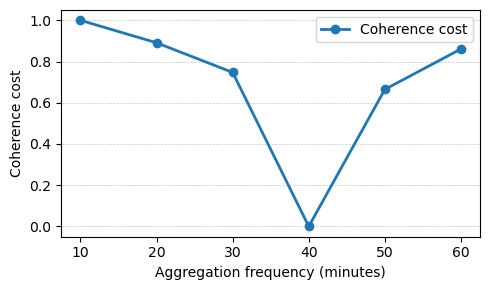

In [311]:
coherence_values = [normalized_coherence[freq] for freq in frequencies]
colors = sns.color_palette("Paired")
plt.figure(figsize=(5, 3))
plt.plot(frequencies, coherence_values, marker='o', color=colors[1], linestyle='-', linewidth=2, label='Coherence cost')

#plt.title('Coût de cohérence en fonction de la fréquence d\'agrégation', fontsize=14)
plt.xlabel('Aggregation frequency (minutes)', fontsize=10)
plt.ylabel('Coherence cost', fontsize=10)

#for x, y in zip(frequencies, coherence_values):
    #plt.text(x, y + 0.01, f'{y:.2f}', ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.legend(loc='upper right')

plt.tight_layout()

plt.show()

In [312]:
min_sensitivity = min(lips_sensitivities.values())
max_sensitivity = max(lips_sensitivities.values())

normalized_sensitivity = {f: (sens - min_sensitivity) / (max_sensitivity - min_sensitivity)
                          for f, sens in lips_sensitivities.items()}

In [313]:
normalized_sensitivity

{10: 1.0,
 20: 0.4767883726903782,
 30: 0.4333868872687891,
 40: 0.5401672608486761,
 50: 0.0,
 60: 0.17296971296360258}

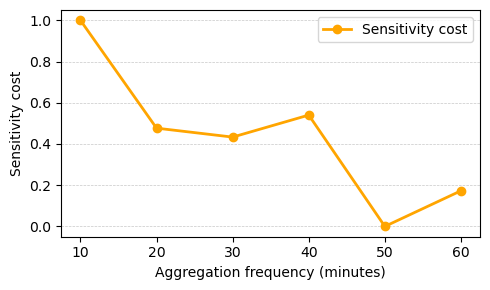

In [314]:
sensitivity_values = [normalized_sensitivity[freq] for freq in frequencies]

plt.figure(figsize=(5, 3))
plt.plot(frequencies, sensitivity_values, marker='o', color='orange', linestyle='-', linewidth=2, label='Sensitivity cost')

#plt.title('Coût de cohérence en fonction de la fréquence d\'agrégation', fontsize=14)
plt.xlabel('Aggregation frequency (minutes)', fontsize=10)
plt.ylabel('Sensitivity cost', fontsize=10)

#for x, y in zip(frequencies, coherence_values):
    #plt.text(x, y + 0.01, f'{y:.2f}', ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.legend(loc='upper right')

plt.tight_layout()

plt.show()

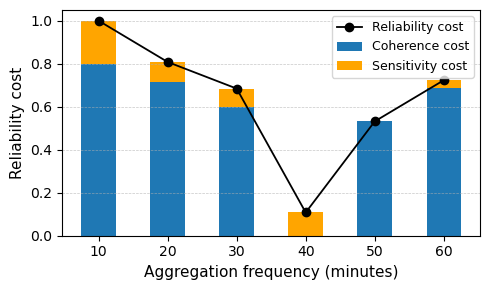

In [316]:
#colors = sns.color_palette("viridis")
colors = sns.color_palette("Paired")
bar_width = 5
frequencies = np.array(frequencies)

coherence_cost = [0.8 * c for c in coherence_values]
sensitivity_cost = [0.2 * s for s in sensitivity_values]
reliability_cost = [coherence_cost[i] + sensitivity_cost[i] for i in range(len(frequencies))]


# Stack the bars
plt.figure(figsize=(5, 3))
plt.bar(frequencies, coherence_cost, bar_width, label='Coherence cost', color=colors[1])
plt.bar(frequencies, sensitivity_cost, bar_width, bottom=coherence_cost, label='Sensitivity cost', color='orange')

plt.plot(frequencies, reliability_cost, color='black', marker='o', linestyle='-', linewidth=1.3, label='Reliability cost')

plt.xlabel('Aggregation frequency (minutes)', fontsize=11)
plt.ylabel('Reliability cost', fontsize=11)


# Add a legend
plt.legend(loc='upper right',prop={'size': 9})

# Add gridlines
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

 ***************************Choice of Aplha & Beta***

In [64]:
frequences = [10,20,30,40,50,60]
coherences = {
    10:coherence10,
    20:coherence20,
    30:coherence30,
    40:coherence40,
    50:coherence50,
    60:coherence60
}


sensitivities = {
    10:lipschitz_sensitivity_10,
    20:lipschitz_sensitivity_20,
    30:lipschitz_sensitivity_30,
    40:lipschitz_sensitivity_40,
    50:lipschitz_sensitivity_50,
    60:lipschitz_sensitivity_60
}


In [65]:
min_coherence = min(coherences.values())
max_coherence = max(coherences.values())

normalized_coherence = {f: (coh - min_coherence) / (max_coherence - min_coherence)
                        for f, coh in coherences.items()}

In [66]:
min_sensitivity = min(sensitivities.values())
max_sensitivity = max(sensitivities.values())

normalized_sensitivity = {f: (sens - min_sensitivity) / (max_sensitivity - min_sensitivity)
                          for f, sens in sensitivities.items()}

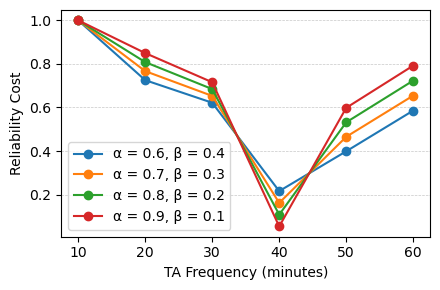

In [68]:
# Sensitivity analysis of parameters Alpha and Beta.
alphas = [0.6, 0.7, 0.8, 0.9]
results = {alpha: [] for alpha in alphas}

for alpha in alphas:
    beta = round(1 - alpha, 2)
    for f in frequences:
        cost = alpha * normalized_coherence[f] + beta * normalized_sensitivity[f]
        results[alpha].append(cost)

# Tracer les courbes
plt.figure(figsize=(4.5, 3))
for alpha in alphas:
    plt.plot(frequences, results[alpha], marker='o', label=f'α = {alpha}, β = {round(1 - alpha, 2)}')

plt.xlabel("TA Frequency (minutes)")
plt.ylabel("Reliability Cost")
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()